# Data Preprocessing - Preparing for one of the top performing models

In this notebook, after an exploratory data analysis is performed on Give Me Some Credit's training set from last notebook, the next step is to do a feature importance evaluation to see whether all these risk drivers are necessary for building the model. 

Preprocessing steps are done here. These preprocessing steps will be the preparatory work for training a XGBoost model on the dataset.

In [79]:
# Main tools we used:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Models:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

# plot utilities:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Python utilities:
import time
import os

In [130]:
# Import Data
df_train = pd.read_csv("cs-training.csv")
df_test = pd.read_csv("cs-test.csv")
df_train.shape


(150000, 12)

## Preprocessing Suggestions <a class="anchor" id="4"></a>

- Remove samples with values of DebtRatio above its 97.5 percentile
- Set 0 <= RevolvingUtilizationOfUnsecuredLines < 10
- For Late Payment Columns NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse,to handle the extreme outlier values (96/98), we can apply Winsorization by replacing them with their nearest non-extreme value. 
- Impute MonthlyIncome with its median or mode, or with a normally distributed variable with MonthlyIncome's mean and standard deviation, or regression imputation.
- Impute NumberOfDependents with its mode

In [132]:
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [133]:
# Preprocess Data

## drop id column which doesn't provide any valuable info
df_train= df_train.drop("Unnamed: 0", axis=1)
df_test = df_test.drop("Unnamed: 0", axis=1)


In [107]:
df_train.shape


(150000, 11)

In [134]:
df_test.shape

(101503, 11)

In [108]:
# Remove samples with values of DebtRatio above its 97.5 percentile
df_train_processed = df_train.loc[df_train["DebtRatio"] <= df_train["DebtRatio"].quantile(0.975)]
df_train_processed.shape


(146250, 11)

In [109]:
# Set 0 <= RevolvingUtilizationOfUnsecuredLines < 13
# 
df_train_processed = df_train_processed.loc[(df_train_processed["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df_train_processed["RevolvingUtilizationOfUnsecuredLines"] <=10)]

df_train_processed.shape

(146021, 11)

In [110]:
# to handle the extreme outlier values (96/98), we can apply Winsorization by replacing them with their nearest non-extreme value.
def winsorize_data(df, column, threshold):
    df[column] = np.where(df[column] > threshold, threshold, df[column])
    return df

In [111]:
# For Late Payment Columns NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse,to handle the extreme outlier values (96/98),
# we can apply Winsorization by replacing them with their nearest non-extreme value.
df_train_processed = winsorize_data(df_train_processed, "NumberOfTimes90DaysLate", 17)
df_train_processed = winsorize_data(df_train_processed, "NumberOfTime60-89DaysPastDueNotWorse", 11)
df_train_processed = winsorize_data(df_train_processed, "NumberOfTime30-59DaysPastDueNotWorse", 13)

In [112]:
df_train_processed.shape

(146021, 11)

In [113]:
df_train_processed.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()

NumberOfTimes90DaysLate
0     137808
1       5159
2       1536
3        656
4        287
5        129
6         78
7         37
8         20
9         19
10         8
11         4
12         2
13         4
14         2
15         2
17       270
Name: NumberOfTimes90DaysLate, dtype: int64

In [114]:
df_train_processed.groupby('NumberOfTime60-89DaysPastDueNotWorse').NumberOfTimes90DaysLate.count()

NumberOfTime60-89DaysPastDueNotWorse
0     138582
1       5604
2       1090
3        315
4        100
5         33
6         16
7          8
8          2
9          1
11       270
Name: NumberOfTimes90DaysLate, dtype: int64

In [115]:
df_train_processed.groupby('NumberOfTime30-59DaysPastDueNotWorse').NumberOfTimes90DaysLate.count()

NumberOfTime30-59DaysPastDueNotWorse
0     122744
1      15578
2       4467
3       1691
4        715
5        324
6        137
7         52
8         25
9         12
10         3
11         1
12         2
13       270
Name: NumberOfTimes90DaysLate, dtype: int64

**NumberOfDependents**

greater than 50% of the non-missing values have 0 dependents, and if someone leaves the field blank it is likely to be due to not having any dependents, we'll replace these values with 0.

In [116]:
# impute dependents with mode
dependents_mode = df_train["NumberOfDependents"].mode()[0] # impute with mode
df_train_processed["NumberOfDependents"] = df_train_processed["NumberOfDependents"].fillna(dependents_mode)
# df_train["NumberOfDependents"] = df_train["NumberOfDependents"].fillna(dependents_mode)
missing_values = df_train_processed["NumberOfDependents"].isna().sum()
print("Number of missing values for NumberOfDependents", missing_values)


Number of missing values for NumberOfDependents 0


**Handle missing data for monthly income**

When handling missing values for the "MonthlyIncome" column in a predictive modeling task,there are several options:

1. **Dropping rows**: If the number of missing values is relatively small compared to the total dataset, you can choose to drop the rows with missing values using the dropna() function. However, this approach may lead to loss of valuable data.

2. **Mean/Median/Mode** imputation: You can fill in the missing values with the mean, median, or mode of the "MonthlyIncome" column. For example, you can calculate the mean income and replace the missing values with that value using the fillna() function: df["MonthlyIncome"].fillna(df["MonthlyIncome"].mean(), inplace=True). Similarly, you can use the median or mode instead of the mean.

3. **Regression imputation**: If you have other variables in your dataset that are strongly correlated with the "MonthlyIncome" column, you can use regression techniques to predict the missing values based on those variables. You can train a regression model using the available data and then use the model to predict the missing values.

4. **Multiple imputation**: Multiple imputation is a technique where missing values are filled in with multiple plausible values, generating multiple complete datasets. Each dataset is then analyzed separately, and the results are combined to obtain the final estimates. This approach accounts for the uncertainty associated with imputing missing values.

In [117]:
missing_values = df_train_processed["MonthlyIncome"].isna().sum()
print("Number of missing values for MonthlyIncome", missing_values)

Number of missing values for MonthlyIncome 26110


First let's take a look at using regression to fill in the missing values for MonthlyIncome:

In [118]:
not_missing = not_missing = df_train_processed.dropna()
target = 'MonthlyIncome'
predictors = [c for c in list(not_missing) if c not in [target,'SeriousDlqin2yrs']]
X_data = not_missing[predictors]
y_data = not_missing[target]
regr = LinearRegression().fit(X_data, y_data)

In [119]:
regr.score(X_data, y_data)

0.023479301577786216

The R2 value obtained is extremely low, indicating poor model performance. Based on this observation, it appears that the most suitable approach would be to replace the missing values in the "MonthlyIncome" column with the median value instead of the mean. This decision is influenced by the presence of extreme outliers in the "MonthlyIncome" variable, where some individuals are earning exceptionally high incomes in the millions of dollars per month.

In [120]:

    #################################### Uncomment below if want median imputation for MonthlyIncome #################################### 
    income_median = df_train_processed["MonthlyIncome"].median()
    df_train_processed["MonthlyIncome"] = df_train_processed["MonthlyIncome"].fillna(income_median)
      
    ################################################################################################################################################ 


    #################################### Uncomment below if want random normal imputation for Monthly Income #################################### 
    # mean = df["MonthlyIncome"].mean()
    # std = df["MonthlyIncome"].std()
    # np.random.seed(0)
    # df.loc[df["MonthlyIncome"].isnull()]["MonthlyIncome"] = np.random.normal(loc=mean, scale=std, size=len(df.loc[df["MonthlyIncome"].isnull()]))
    # impute_dic = {
    #     "MonthlyIncome": {
    #         "mean": mean,
    #         "std": std
    #     },
    #     "NumberOfDependents": {
    #         "mode": dependents_mode
    #     }
    # }
    ################################################################################################################################################ 



In [121]:
missing_values_MonthlyIncome = df_train_processed["MonthlyIncome"].isna().sum()
print("Number of missing values for MonthlyIncome", missing_values_MonthlyIncome)


Number of missing values for MonthlyIncome 0


In [131]:
df_train_processed.shape

(146021, 11)

In [142]:
df_train_processed.to_csv('processed_data_train.csv', index=False)


### Feature Importance

In [124]:
train_X = df_train_processed.drop(["SeriousDlqin2yrs"], axis=1)
train_y = np.log1p(df_train_processed["SeriousDlqin2yrs"].values)

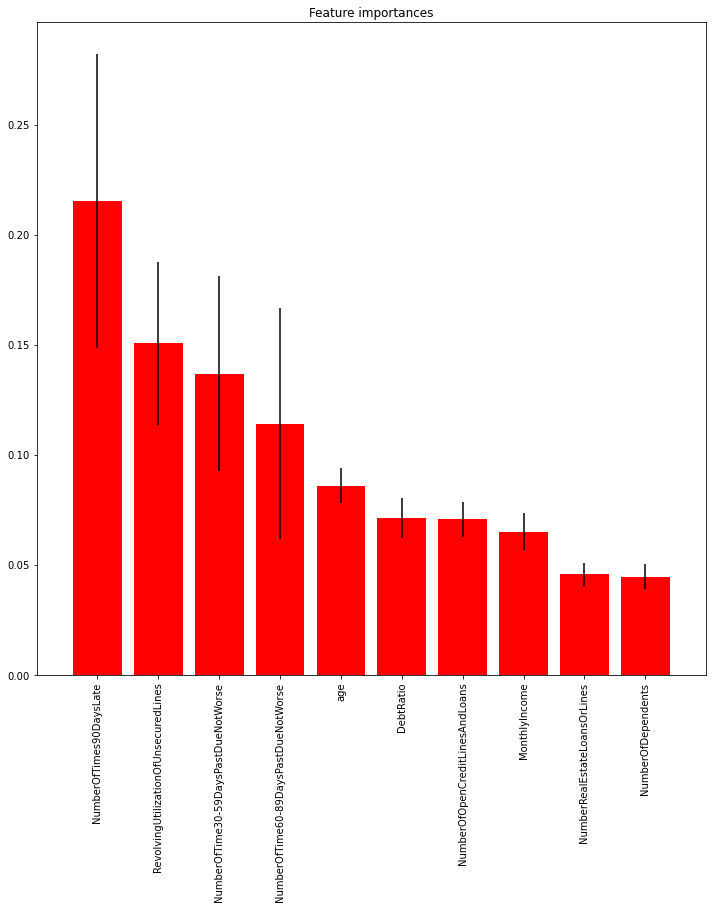

In [125]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plotando as importâncias ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [126]:
def plot_new_feature_distribution(df1, df2, label1, label2, features, n):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,n,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,n,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

### Correlation among risk drivers

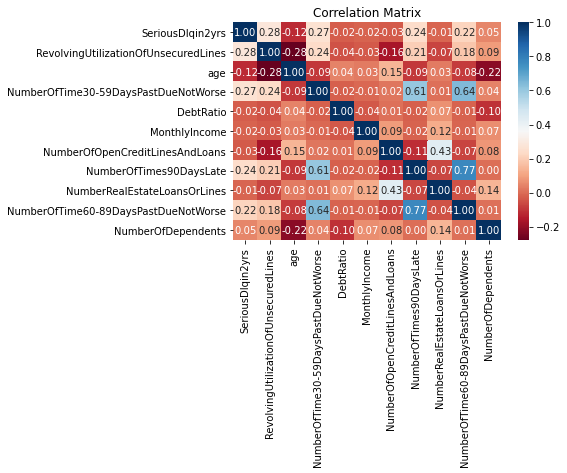

In [150]:
correlations = df_train_processed.corr()
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="RdBu")
plt.title("Correlation Matrix")
plt.show()

In [154]:
correlations = df_train_processed.corr()
high_correlations = np.where(np.abs(correlations) > 0.5)
correlation_pairs = [(df_train_processed.columns[i], df_train_processed.columns[j]) for i, j in zip(*high_correlations) if i != j]

for pair in correlation_pairs:
    print(f"Correlation between {pair[0]} and {pair[1]} is greater than 0.5")

Correlation between NumberOfTime30-59DaysPastDueNotWorse and NumberOfTimes90DaysLate is greater than 0.5
Correlation between NumberOfTime30-59DaysPastDueNotWorse and NumberOfTime60-89DaysPastDueNotWorse is greater than 0.5
Correlation between NumberOfTimes90DaysLate and NumberOfTime30-59DaysPastDueNotWorse is greater than 0.5
Correlation between NumberOfTimes90DaysLate and NumberOfTime60-89DaysPastDueNotWorse is greater than 0.5
Correlation between NumberOfTime60-89DaysPastDueNotWorse and NumberOfTime30-59DaysPastDueNotWorse is greater than 0.5
Correlation between NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate is greater than 0.5


"NumberOfTime30-59DaysPastDueNotWorse," "NumberOfTimes90DaysLate," and "NumberOfTime60-89DaysPastDueNotWorse," with high correlation, indicating they are related, you can consider combining them into a single meaningful feature. One possible approach is to create a new feature that represents the total number of times a person has been past due across all three time windows.

In [157]:
df_train_created = df_train_processed
# Create a new column 'TotalPastDue' by summing the values of the three columns
df_train_created['TotalPastDue'] = df_train_processed['NumberOfTime30-59DaysPastDueNotWorse'] + df_train_processed['NumberOfTimes90DaysLate'] + df_train_processed['NumberOfTime60-89DaysPastDueNotWorse']

# Drop the individual columns if desired
df_train_created = df_train_processed.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], axis=1)

In [159]:
df_train_created

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,TotalPastDue
0,1,0.766127,45,0.802982,9120.0,13,6,2.0,2
1,0,0.957151,40,0.121876,2600.0,4,0,1.0,0
2,0,0.658180,38,0.085113,3042.0,2,0,0.0,2
3,0,0.233810,30,0.036050,3300.0,5,0,0.0,0
4,0,0.907239,49,0.024926,63588.0,7,1,0.0,1
...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0.404293,3400.0,7,0,0.0,0
149995,0,0.040674,74,0.225131,2100.0,4,1,0.0,0
149996,0,0.299745,44,0.716562,5584.0,4,1,2.0,0
149998,0,0.000000,30,0.000000,5716.0,4,0,0.0,0


## test dataset processing

When filling missing data in the test dataset, it is generally recommended to use the median (or any other imputation value) obtained from the training dataset. This is because the model has been trained on the training dataset, and using the same imputation strategy ensures consistency in handling missing values.

In [143]:
## fill test dataset MonthlyIncome with median from train dataset
df_test_processed = df_test
df_test_processed["MonthlyIncome"] = df_test["MonthlyIncome"].fillna(income_median)

In [144]:
df_test_processed["MonthlyIncome"].isna().sum()

0

In [145]:
df_test_processed["NumberOfDependents"] = df_test_processed["NumberOfDependents"].fillna(dependents_mode)

In [146]:
df_test_processed["NumberOfDependents"].isna().sum()

0

In [158]:
df_test_created = df_test_processed.copy()

# Create a new column 'TotalPastDue' by summing the values of the three columns
df_test_created['TotalPastDue'] = df_test_processed['NumberOfTime30-59DaysPastDueNotWorse'] + df_test_processed['NumberOfTimes90DaysLate'] + df_test_processed['NumberOfTime60-89DaysPastDueNotWorse']

# Drop the individual columns if desired
df_test_created = df_test_processed.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], axis=1)

In [ ]:
df_train_processed.to_csv('processed_data_test.csv', index=False)

In [161]:
df_test_processed.to_csv('processed_data_test.csv', index=False)


In [163]:
df_train_created.to_csv('df_train_created.csv', index=False)

In [169]:
df_test_created = df_test_processed
# Create a new column 'TotalPastDue' by summing the values of the three columns
df_test_created['TotalPastDue'] = df_test_processed['NumberOfTime30-59DaysPastDueNotWorse'] + df_test_processed['NumberOfTimes90DaysLate'] + df_test_processed['NumberOfTime60-89DaysPastDueNotWorse']

# Drop the individual columns if desired
df_test_created = df_test_processed.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], axis=1)

In [170]:
df_test_created


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,TotalPastDue
0,NaN,0.885519,43,0.177513,5700.0,4,0,0.0,0
1,NaN,0.463295,57,0.527237,9141.0,15,4,2.0,0
2,NaN,0.043275,59,0.687648,5083.0,12,1,2.0,0
3,NaN,0.280308,38,0.925961,3200.0,7,2,0.0,1
4,NaN,1.000000,27,0.019917,3865.0,4,0,1.0,0
...,...,...,...,...,...,...,...,...,...
101498,NaN,0.282653,24,0.068522,1400.0,5,0,0.0,0
101499,NaN,0.922156,36,0.934217,7615.0,8,2,4.0,3
101500,NaN,0.081596,70,836.000000,5400.0,3,0,0.0,0
101501,NaN,0.335457,56,3568.000000,5400.0,8,2,3.0,1


In [171]:
df_train_created


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,TotalPastDue
0,1,0.766127,45,0.802982,9120.0,13,6,2.0,2
1,0,0.957151,40,0.121876,2600.0,4,0,1.0,0
2,0,0.658180,38,0.085113,3042.0,2,0,0.0,2
3,0,0.233810,30,0.036050,3300.0,5,0,0.0,0
4,0,0.907239,49,0.024926,63588.0,7,1,0.0,1
...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0.404293,3400.0,7,0,0.0,0
149995,0,0.040674,74,0.225131,2100.0,4,1,0.0,0
149996,0,0.299745,44,0.716562,5584.0,4,1,2.0,0
149998,0,0.000000,30,0.000000,5716.0,4,0,0.0,0


In [172]:
df_test_created.to_csv('df_test_created.csv', index=False)
